## Importing Libraries

##  Image Processing for Microscopic Images

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from co_mof import grayscale_image, apply_otsu_thresholding, apply_rc_thresholding, display_binary_images_with_histogram
from PIL import Image
import cv2

# TODO: use config
image_path = 'dataset/assets/images/EXP8(SolventVolumes-II-PipetteRepeat)/EXP8COND11II/EXP8_EVOS_20X_001.tif'

# Load and preprocess the image
image = Image.open(image_path)
# image = cv2.imread(image_path)
image_gray = grayscale_image(image)

# Apply Mahotas Otsu thresholding
otsu_thresh, bin_otsu = apply_otsu_thresholding(image_gray)  # TODO: delete otsu
# Apply Mahotas RC thresholding
rc_thresh, bin_rc = apply_rc_thresholding(image_gray)

# TODO: we calculate bin_otsu and bin_rc, but only use bin_rc again. Why do we need bin_otsu?

# Display the results  # TODO: markdown explanation of why this figure is important
display_binary_images_with_histogram(image_gray, otsu_thresh, bin_otsu, rc_thresh, bin_rc)

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-15:Bad number of channels) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<1>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 3


## Finding the exact area using the scale bar

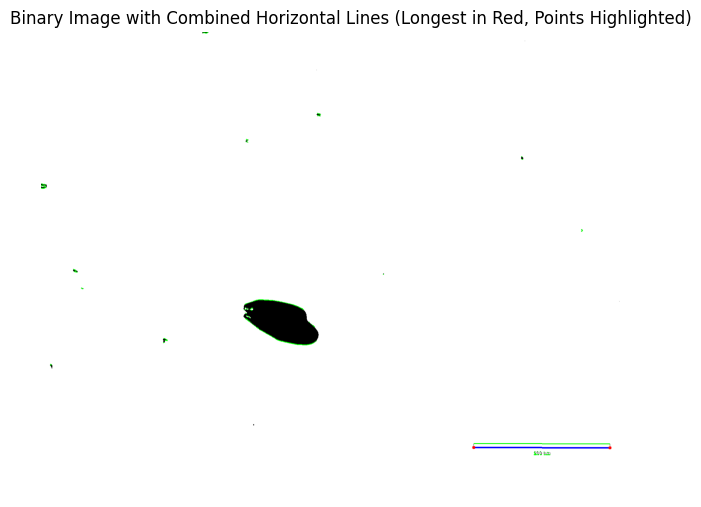

Length of the longest line in pixels: 450.00
Actual length per pixel: 0.4444 micrometers per pixel


In [2]:
from co_mof import detect_horizontal_lines, combine_close_lines, overlay_horizontal_lines, display_overlay
from skimage import measure
import numpy as np


# TODO: what is calculated in this code block that is used in future code blocks? How do these calculations fit into the big picture?
# TODO: calculations should be in functions

# Detect all contours in the binary image using skimage
contours = measure.find_contours(bin_rc, level=0.8)

# Detect horizontal lines in contours
horizontal_lines = detect_horizontal_lines(contours)

# Combine horizontal lines that are close to each other
combined_lines = combine_close_lines(horizontal_lines, pixel_tolerance=5)

# Overlay combined horizontal lines on the binary image and highlight the longest in red
overlay_image, longest_line = overlay_horizontal_lines(bin_rc, combined_lines)

# Display the overlay
display_overlay(overlay_image)

# Assuming the actual length of the longest line is 200 micrometers  # TODO: Why 200?
actual_length_micrometers = 200

# Print details of the longest line  # TODO: should be in function
if longest_line:
    x1, y1, x2, y2 = longest_line
    length_in_pixels = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    length_per_pixel = actual_length_micrometers / length_in_pixels
    print(f"Length of the longest line in pixels: {length_in_pixels:.2f}")
    print(f"Actual length per pixel: {length_per_pixel:.4f} micrometers per pixel")
    
else:
    print("No horizontal lines detected.")
    length_in_pixels = 450
    length_per_pixel = actual_length_micrometers / length_in_pixels

## RC Thresholding and Morphological Closing

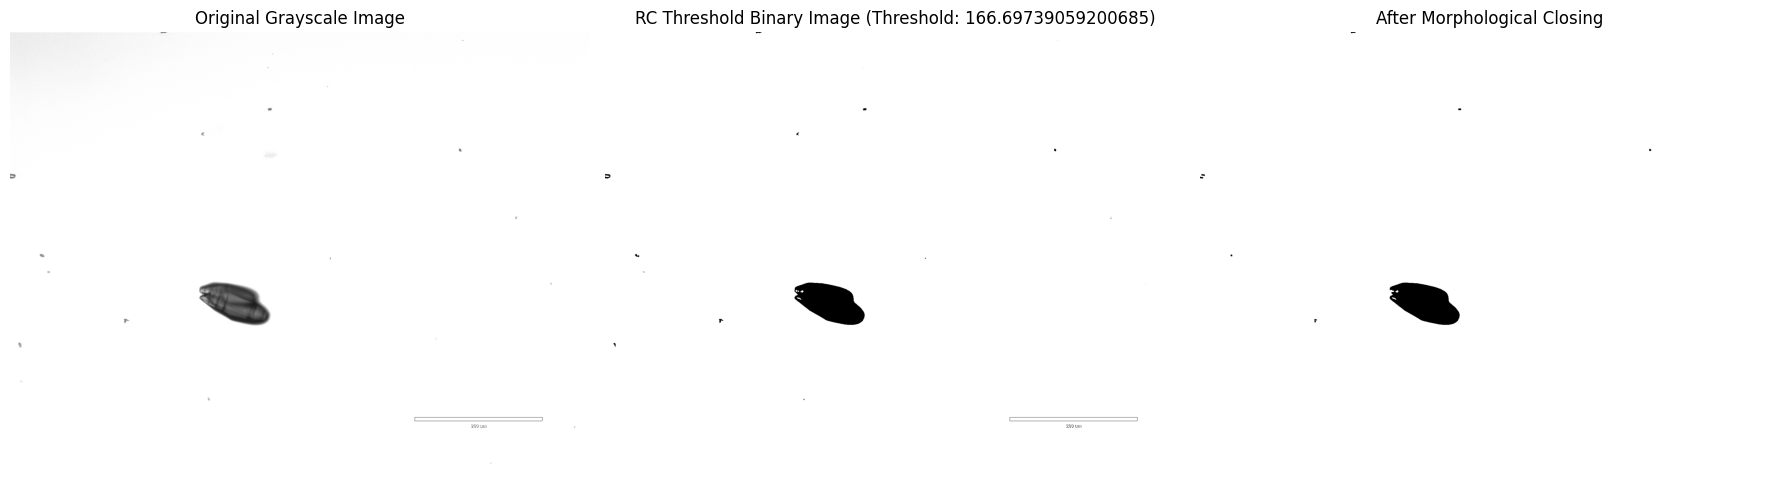

In [3]:
from co_mof import apply_morphological_closing, display_rc_closing_results

# Apply RC thresholding
# rc_thresh, bin_rc = apply_rc_thresholding(image_gray)  # TODO: already did this in cell 1?

# Apply morphological closing on the RC thresholded binary image
closed_image = apply_morphological_closing(bin_rc)

# Display results before and after morphological closing
display_rc_closing_results(image_gray, rc_thresh, bin_rc, closed_image)

## Contour Detection and Filtering for White Regions

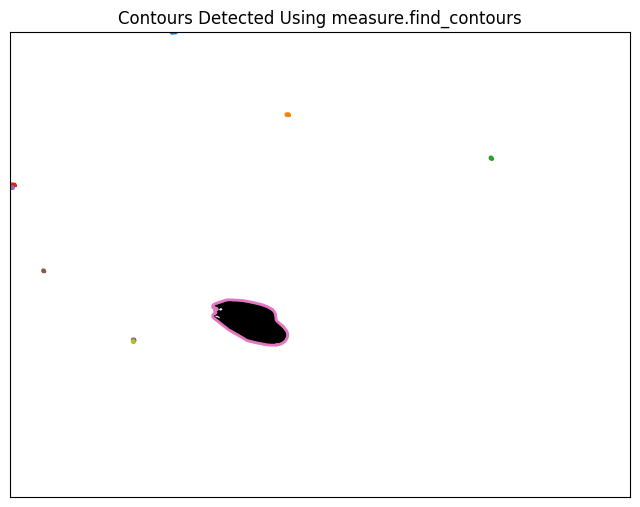

In [4]:
from co_mof import is_contour_enclosing_white_region, normalize_and_find_contours, filter_and_remove_white_region_contours, display_contours

# Example usage:
# Normalize the closing image and find contours
contours = normalize_and_find_contours(closed_image, contour_level=0.8)

# Filter out contours that enclose white regions
contours = filter_and_remove_white_region_contours(closed_image, contours)

# Display the contours on the closing result
display_contours(closed_image, contours)

## Displaying Contours on the Original Color Image

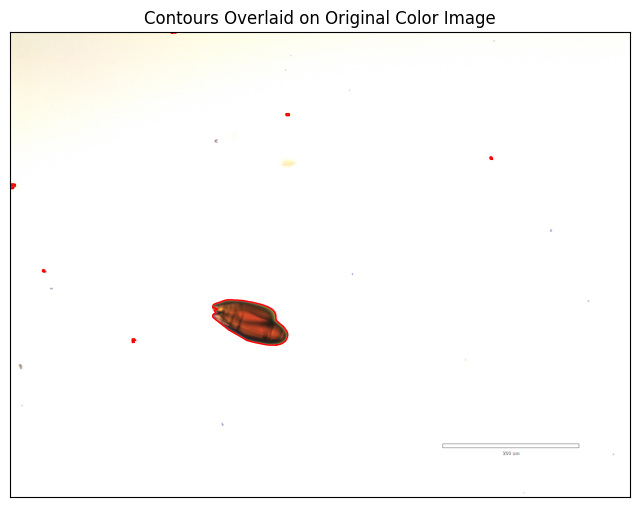

In [5]:
from co_mof import display_contours_on_original_color

# Example usage:
# Load the original color image and the grayscale image for processing
# TODO: try image.mode
original_image = Image.open(image_path).convert('RGB')  # Load as color  # TODO: image was already loaded in earlier code block

# Display the contours overlaid on the original color image
display_contours_on_original_color(original_image, contours)


## Contour Classification by Convexity and Boundary Detection

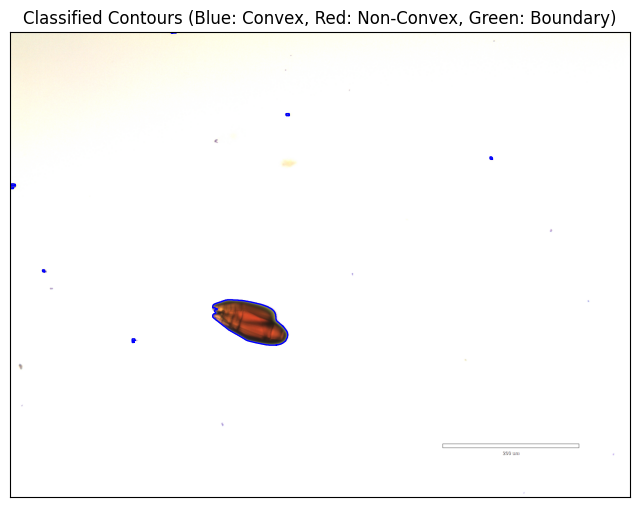

In [6]:
from co_mof import classify_contours_by_convexity, display_classified_contours_on_original_color

# Example usage:
# Classify contours based on convexity and identify boundary contours
blue_contours, red_contours, boundary_contours = classify_contours_by_convexity(image_gray.shape, contours)

# Display the contours overlaid on the original color image, classified by convexity and boundary
display_classified_contours_on_original_color(original_image, blue_contours, red_contours, boundary_contours)

# Activated IFF less than 2 Detected Contours

## Overlaying Minimum Bounding Boxes and Calculating Aspect Ratios and Areas 

In [7]:
from co_mof import process_and_overlay_if_few_contours  # TODO: this looks like it should be broken up into filter & show fxns

# Example Usage:
# Assuming `original_image`, `blue_contours`, `red_contours`, and `boundary_contours` are defined
blue_aspect_ratios, blue_areas = process_and_overlay_if_few_contours(
    original_image, blue_contours, red_contours, boundary_contours, length_per_pixel
)

# Output aspect ratios and areas
print("All Aspect Ratios:", blue_aspect_ratios)
print("All Areas:", blue_areas)

Total contours (9) are sufficient. Skipping bounding box overlay.
All Aspect Ratios: []
All Areas: []


# Else (If more than 2 detected contours)

## Processing Blue Contours: Areas and Aspect Ratios

Total areas: 9, Total aspect ratios: 9


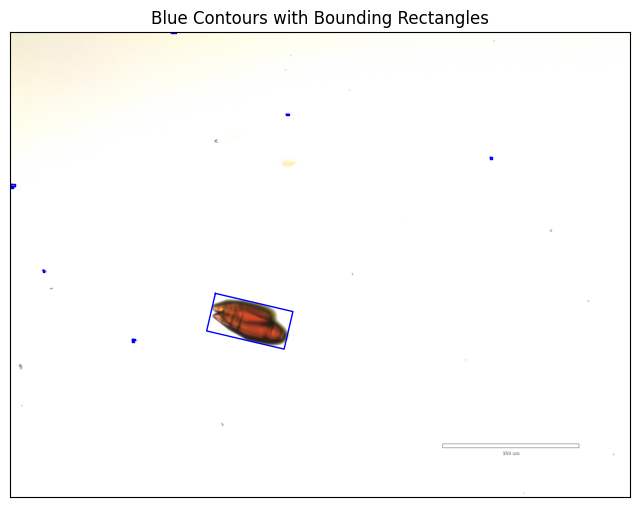

In [8]:
from co_mof import process_blue_contours  # TODO: vague function name
blue_areas, blue_aspect_ratios = process_blue_contours(image_gray, original_image, blue_contours)

## Plotting Histograms with KDE Curves, Peaks, and Standard Deviation

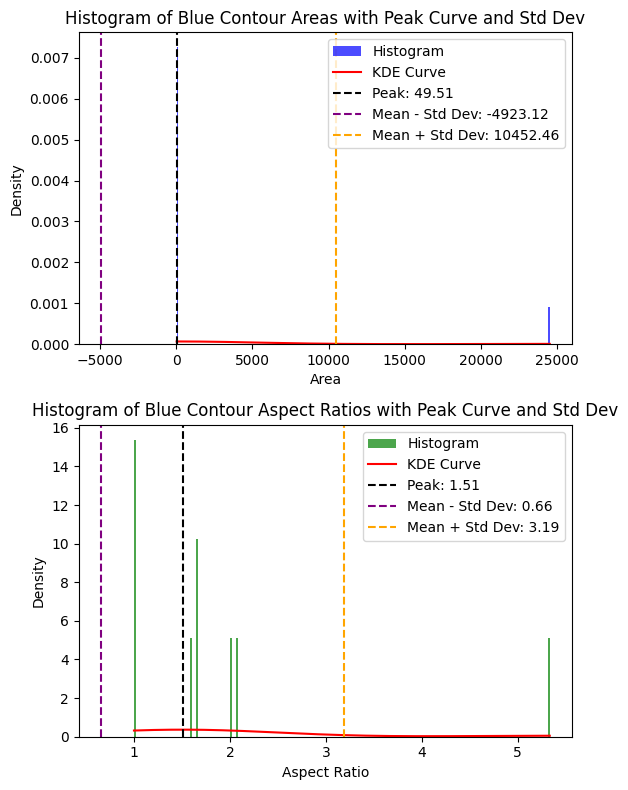

Peak Area: 49.50850850850851
Mean Area: 2764.6666666666665, Std Dev Area: 7687.791172444208
Peak Aspect Ratio: 1.5075075075075075
Mean Aspect Ratio: 1.9256064634334922, Std Dev Aspect Ratio: 1.266999653810354


In [9]:
from co_mof import plot_top_bottom_histograms_with_peak_curve_and_std
# Example usage:
peak_area, peak_ar, mean_area, std_area, mean_ar, std_ar = plot_top_bottom_histograms_with_peak_curve_and_std(blue_areas, blue_aspect_ratios)

# Print the peaks and standard deviations  # TODO: should be in function
print(f"Peak Area: {peak_area}")
print(f"Mean Area: {mean_area}, Std Dev Area: {std_area}")
print(f"Peak Aspect Ratio: {peak_ar}")
print(f"Mean Aspect Ratio: {mean_ar}, Std Dev Aspect Ratio: {std_ar}")

## Filtering and Overlaying Contours with Area Limits

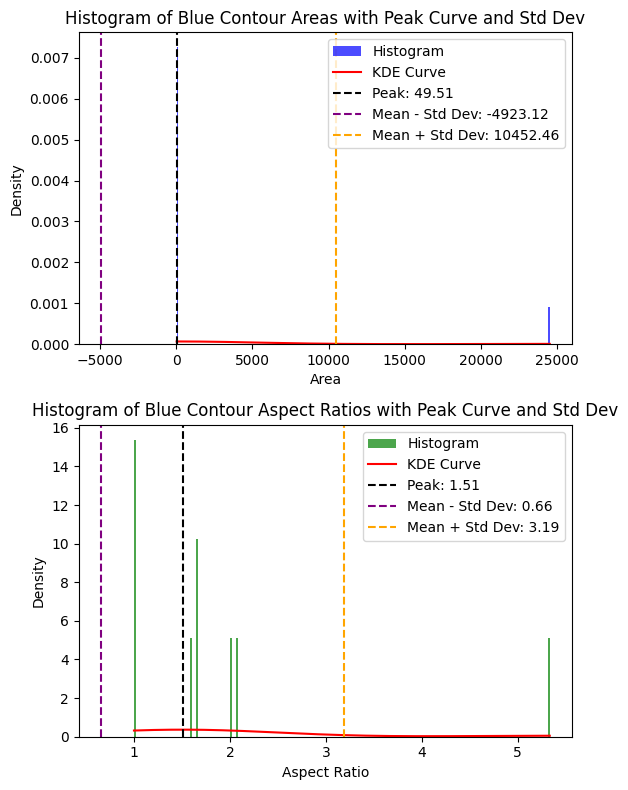

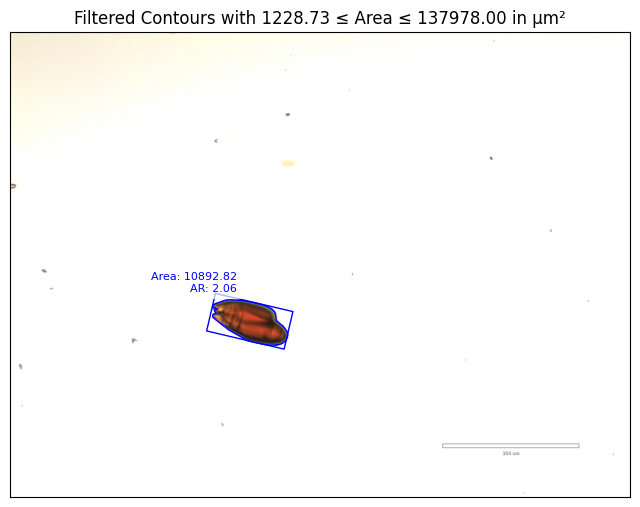

Number of Filtered Blue Contours: 1
Number of Red contours: 0
Number of Green contours: 0
Filtered Blue Contour Areas:
Contour 1: Area = 10892.820035725532


In [10]:
from co_mof import filter_and_overlay_all_contours_with_upper_limit

# Example usage:
# Assuming `areas`, `original_image`, `image_gray`, `blue_contours`, `red_contours`, and `green_contours` are defined
peak_area, _, mean_area, std_dev_area, mean_ar, _ = plot_top_bottom_histograms_with_peak_curve_and_std(
    blue_areas, blue_aspect_ratios
)

# TODO: put below in function
# Replacement of Value (To ensure most contours are detected)
if mean_area > 5000:
    mean_area = 500
            
elif mean_area < 1000:
    mean_area = 200

filtered_blue_contours, blue_contour_areas, filtered_red_contours, filtered_green_contours, blue_aspect_ratios = filter_and_overlay_all_contours_with_upper_limit(
    original_image, image_gray, blue_contours, red_contours, boundary_contours, mean_area, std_dev_area, peak_area, length_per_pixel
)

print(f"Number of Filtered Blue Contours: {len(filtered_blue_contours)}")
print(f"Number of Red contours: {len(filtered_red_contours)}")
print(f"Number of Green contours: {len(filtered_green_contours)}")

actual_blue_contour_areas = []

# Print the areas of filtered blue contours
print("Filtered Blue Contour Areas:")
for idx, blue_contour_area in enumerate(blue_contour_areas):
    blue_contour_area = blue_contour_area * length_per_pixel
    actual_blue_contour_areas.append(blue_contour_area)
    print(f"Contour {idx + 1}: Area = {blue_contour_area}")

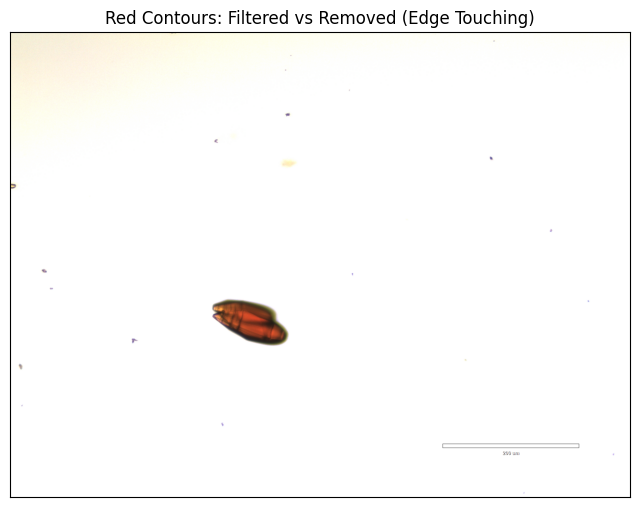

In [11]:
from co_mof import remove_edge_touching_contours_and_display

# Remove and display red contours that touch the edges before filtering
filtered2_red_contours = remove_edge_touching_contours_and_display(filtered_red_contours, image_gray, original_image, color="red")

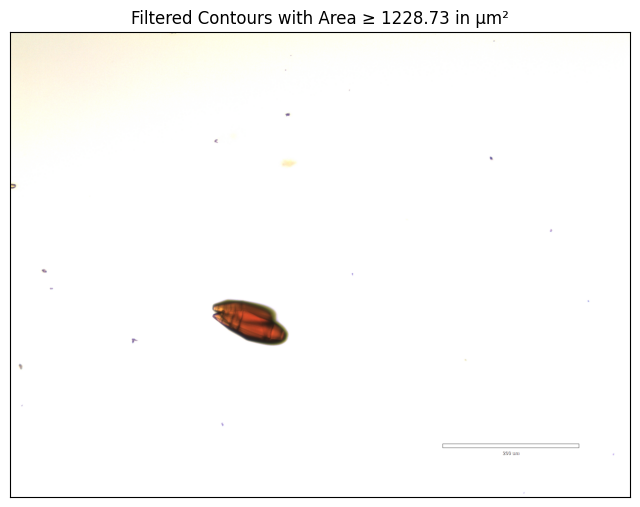

Actual Contour Areas for Filtered Red Contours:


In [12]:
from co_mof import plot_bounding_boxes_and_calculate_contour_area

red_contour_areas = plot_bounding_boxes_and_calculate_contour_area(
    filtered2_red_contours, original_image, mean_area, length_per_pixel, color="red"
)

# Print the calculated contour areas
print("Actual Contour Areas for Filtered Red Contours:")
for idx, area in enumerate(red_contour_areas):
    print(f"Contour {idx + 1}: Area = {area:.2f} µm²")

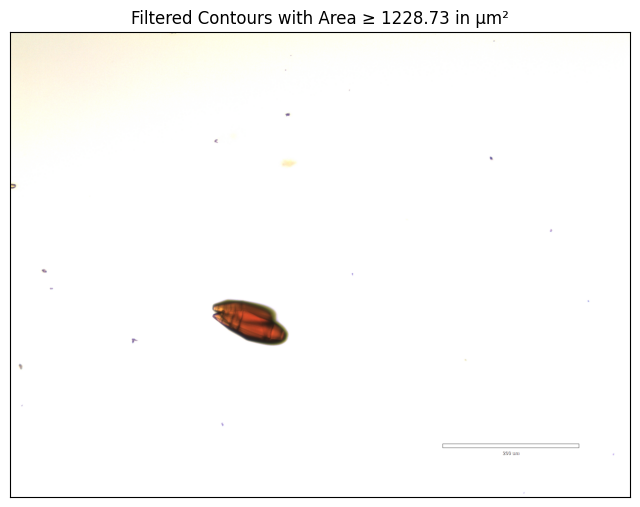

Actual Contour Areas for Filtered Red Contours:


In [13]:
from co_mof import plot_bounding_boxes_and_display_contour_areas

red_contour_areas = plot_bounding_boxes_and_calculate_contour_area(  # TODO: is this the correct function?
    filtered2_red_contours, original_image, length_per_pixel, mean_area, color="red"
)

# Print the calculated contour areas
print("Actual Contour Areas for Filtered Red Contours:")
for idx, area in enumerate(red_contour_areas):
    print(f"Contour {idx + 1}: Area = {area:.2f} µm²")

## Data Analysis

In [14]:
from co_mof import create_summary_table

# Example Data
# Generate the summary table
summary_table = create_summary_table(
    blue_aspect_ratios, 
    actual_blue_contour_areas, red_contour_areas
)

# Display the summary table
display(summary_table)

,Category,Count,Mean Aspect Ratio,Mean Area (µm²)
0,Single Crystals,1,2.06,10892.82
1,Clusters,0,-,0.00


In [15]:
# TODO: confused about this - it is a duplicate function and uses styling that requires extra dependencies

# import pandas as pd
# from IPython.display import display

# def create_summary_table(
#     aspect_ratios_single,
#     areas_single, areas_clusters
# ):
#     """
#     Create a summary table with the count of contours, mean aspect ratios, and mean areas for single crystals,
#     overlapping crystals, and clusters.

#     Parameters:
#     - single_crystals: List of single crystals.
#     - overlapping_crystals: List of overlapping crystals.
#     - clusters: List of clusters.
#     - aspect_ratios_single: List of aspect ratios for single crystals.
#     - aspect_ratios_overlapping: List of aspect ratios for overlapping crystals.
#     - aspect_ratios_clusters: List of aspect ratios for clusters.
#     - areas_single: List of areas for single crystals.
#     - areas_overlapping: List of areas for overlapping crystals.
#     - areas_clusters: List of areas for clusters.

#     Returns:
#     - summary_table: Pandas DataFrame containing the summary.
#     """
#     # Calculate counts
#     count_single_crystals = len(aspect_ratios_single)
#     count_clusters = len(areas_clusters)

#     # Calculate mean aspect ratios
#     mean_ar_single = round(np.mean(aspect_ratios_single), 2) if aspect_ratios_single else 0
#     mean_ar_clusters = "-"

#     # Calculate mean areas
#     mean_area_single = round(np.mean(areas_single), 2) if areas_single else 0
#     mean_area_clusters = round(np.mean(areas_clusters), 2) if areas_clusters else 0

#     # Calculate totals
#     total_count = count_single_crystals 
#     total_aspect_ratios = aspect_ratios_single 
#     total_mean_ar = round(np.mean(total_aspect_ratios), 2) if total_aspect_ratios else 0


#     # Create the summary table
#     summary_table = pd.DataFrame({
#         "Category": ["Single Crystals", "Overlapping Crystals", "Total", "Clusters"],
#         "Count": [count_single_crystals, count_clusters],
#         "Mean Aspect Ratio": [mean_ar_single,   mean_ar_clusters],
#         "Mean Area (µm²)": [mean_area_single, mean_area_clusters]
#     })

#     return summary_table

# # Example Data
# # Generate the summary table

# # Format specific columns to 2 decimal points
# summary_table["Mean Aspect Ratio"] = summary_table["Mean Aspect Ratio"].apply(
#     lambda x: f"{float(x):.2f}" if isinstance(x, (int, float)) else x
# )
# summary_table["Mean Area (µm²)"] = summary_table["Mean Area (µm²)"].apply(
#     lambda x: f"{float(x):.2f}" if isinstance(x, (int, float)) else x
# )

# # Display the summary table with Arial font styling and centering
# styled_table = summary_table.style.set_table_styles([
#     {'selector': 'th', 'props': [('font-family', 'Arial'), ('font-size', '12px'), ('text-align', 'center')]},
#     {'selector': 'td', 'props': [('font-family', 'Arial'), ('font-size', '12px'), ('text-align', 'center')]},
#     {'selector': 'table', 'props': [('margin-left', 'auto'), ('margin-right', 'auto')]}  # Center the table
# ])
# display(styled_table)

In [16]:
from co_mof import calculate_summary_with_std

# Calculate summary table with standard deviations
summary_table_with_std = calculate_summary_with_std(
    blue_aspect_ratios,
    actual_blue_contour_areas, red_contour_areas
)

# Ensure the plot displays the categories in the correct order
correct_order = ["Single Crystals", "Clusters"]
summary_table_with_std = summary_table_with_std.iloc[::-1].reset_index(drop=True)

# Update category labels to have one word per line
summary_table_with_std["Category"] = summary_table_with_std["Category"].replace({
    "Single Crystals": "Single\nCrystals",
    "Clusters": "Clusters"
})

# # Define bar width
# bar_width = 0.5  # Adjust this value for the desired bar width

# # Plot horizontal bar plot for counts
# plt.figure(figsize=(5, 4))
# plt.barh(summary_table_with_std["Category"], summary_table_with_std["Count"], color='dodgerblue', height=bar_width)
# plt.xlabel("Count", fontsize=14)
# # plt.ylabel("Category", fontsize=14)
# # plt.title("Counts of Crystals and Clusters", fontsize=16)
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

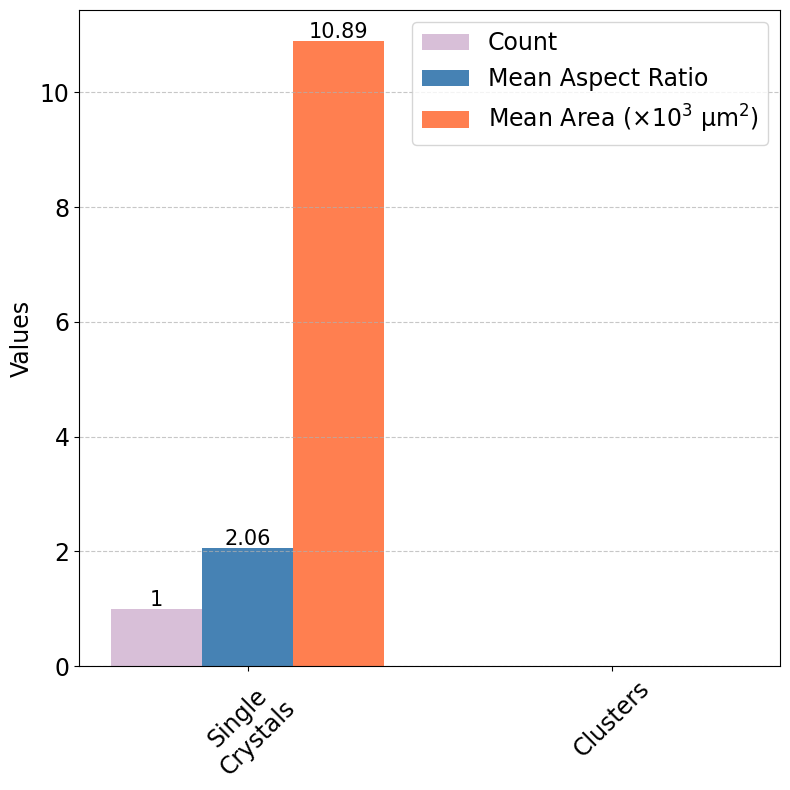

In [17]:
# TODO: should be in a function
from matplotlib import pyplot as plt

# Extract data from the summary table
categories = summary_table_with_std["Category"][::-1]
counts = summary_table_with_std["Count"][::-1]
mean_aspect_ratios = summary_table_with_std["Mean Aspect Ratio"][::-1]
mean_areas = summary_table_with_std["Mean Area (µm²)"][::-1]

# Define bar positions and width
bar_width = 0.25
indices = np.arange(len(categories))

# Convert Mean Aspect Ratio and Mean Area to floats, handling non-numeric values like "-"
mean_aspect_ratios = [float(val) if val != "-" else 0 for val in mean_aspect_ratios]
mean_areas = [float(val) if val != "-" else 0 for val in mean_areas]

# Normalize Mean Area for better visualization alongside Count and Aspect Ratio
area_scaling_factor = 1e3  # Adjust this for better scaling
mean_areas_scaled = [area / area_scaling_factor for area in mean_areas]

# Plot grouped vertical bar chart
fig, ax = plt.subplots(figsize=(8, 8))

# Add bars for Count
bars_count = plt.bar(indices - bar_width, counts, width=bar_width, color='thistle', label='Count')

# Add bars for Mean Aspect Ratio
bars_aspect = plt.bar(indices, mean_aspect_ratios, width=bar_width, color='steelblue', label='Mean Aspect Ratio')

# Add bars for Mean Area (scaled)
bars_area = plt.bar(indices + bar_width, mean_areas_scaled, width=bar_width, color='coral', label=r"Mean Area ($\times10^3$ µm$^2$)")


for bars, data in zip([bars_count, bars_aspect, bars_area], [counts, mean_aspect_ratios, mean_areas_scaled]):
    for bar, value in zip(bars, data):
        if value != 0:  # Ignore labels for bars with a value of 0
            plt.text(
                bar.get_x() + bar.get_width() / 2,  # Center the text horizontally on the bar
                bar.get_height() + 0.05,  # Position slightly above the bar
                f"{value:.2f}" if isinstance(value, float) else f"{int(value)}",  # Format the text
                ha='center', fontsize=15
            )

# Add labels and legend
plt.ylabel("Values", fontsize=17)
plt.xticks(indices, categories, fontsize=17, rotation=45)
plt.yticks(fontsize=17)
plt.legend(fontsize=17, loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a title
# plt.title("Counts, Aspect Ratios, and Areas by Category", fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()

In [18]:
## if no blue contour then print print there are bno single crystals detected 

In [19]:
# TODO: what do these hard-coded values mean?
a = actual_blue_contour_areas +  [556, 58280, 571.55, 2523.10, 955.2]
b = blue_aspect_ratios + [1.31, 1.30, 1.15, 1.07, 1.22]
print(a)
print(b)

[np.float64(10892.820035725532), 556, 58280, 571.55, 2523.1, 955.2]
[2.063791504234762, 1.31, 1.3, 1.15, 1.07, 1.22]


In [20]:
Con23_2_Area = [228.0, 484.0, 167.11111111111111, 153.33333333333331, 234.66666666666666, 118.66666666666666, 236.44444444444443, 136.44444444444443, 166.2222222222222, 710.2222222222222, 130.66666666666666, 214.66666666666666, 203.1111111111111, 130.22222222222223, 606.6666666666666, 115.1111111111111, 164.0, 155.11111111111111, 165.77777777777777, 403.55555555555554, 180.0, 112.44444444444444, 201.77777777777777, 148.44444444444443, 159.55555555555554, 395.55555555555554, 127.55555555555554, 344.4444444444444, 225.77777777777777, 396.88888888888886, 111.55555555555554, 161.33333333333331, 312.0, 541.3333333333333, 126.66666666666666, 192.88888888888889, 775.5555555555555, 144.0, 199.55555555555554, 279.1111111111111, 478.2222222222222, 116.88888888888889, 134.22222222222223] + [396.0, 165.33333333333331, 280.0, 150.2222222222222, 257.77777777777777, 152.0, 135.55555555555554, 266.22222222222223, 258.66666666666663, 207.55555555555554, 271.1111111111111, 184.0, 141.33333333333331, 208.44444444444443, 272.0, 516.4444444444445, 273.77777777777777, 124.88888888888889, 319.55555555555554, 533.7777777777777, 136.0, 191.55555555555554, 176.88888888888889, 178.66666666666666, 356.0, 155.11111111111111, 235.55555555555554, 1257.7777777777776, 117.33333333333333, 428.88888888888886, 233.77777777777777, 155.55555555555554, 188.44444444444443, 117.77777777777777, 165.33333333333331, 192.44444444444443, 579.1111111111111, 111.55555555555554, 126.22222222222221, 168.88888888888889, 180.44444444444443, 120.44444444444444, 117.77777777777777, 167.11111111111111, 127.55555555555554, 155.11111111111111, 414.66666666666663, 233.33333333333331, 179.11111111111111, 351.55555555555554, 645.7777777777777, 284.0, 130.22222222222223, 293.3333333333333, 119.55555555555554, 408.4444444444444, 367.55555555555554, 207.55555555555554, 137.77777777777777, 217.77777777777777, 264.0, 518.6666666666666, 124.0, 386.22222222222223]
Con23_2_AR = [1.6791667450852932, 3.1580882081327153, 1.1304347543906155, 1.368421052631579, 1.4090909090909092, 1.1493505933117583, 1.7121211650428652, 1.0370370814386605, 1.4531248090221216, 1.110083311086813, 1.2142858060339512, 1.3548386759950246, 2.7013577600598353, 1.0370370814386605, 2.308080830719949, 1.4850747697069824, 1.5693214061792973, 2.2857142857142856, 1.4868422101010064, 1.9226190385397957, 1.1388889814388847, 1.9220778457621848, 1.8299321777375521, 2.93359370992232, 1.6250000280979002, 2.049773693549172, 1.105263157894737, 2.8124997827442275, 1.331858452490457, 1.9817352959431758, 1.1232877184564491, 1.6750000871579067, 1.68, 1.136729178851498, 1.0858368269510505, 1.6913043492364148, 2.3593313471229282, 1.1923076843272242, 1.6279068102861503, 3.6985294780222397, 1.4303029163378402, 2.345238016189199, 1.4166666853986] + [1.473751485344717, 1.2370370777385211, 1.4164136319973912, 1.0958902793285143, 2.413711395291749, 1.5, 1.0828025353951647, 1.3593750173251655, 2.6237623534909345, 1.1690141123684565, 1.0520133501885944, 1.0833333333333333, 1.5277778106864288, 1.2857142857142858, 1.3846153846153846, 1.7304217786710683, 1.1111111111111112, 1.600000050688486, 1.2673266585163494, 1.2, 2.4878048453548747, 2.3999998952124124, 1.3157894736842106, 1.012048271081387, 1.1404254577399233, 1.5336132953293264, 1.0399201756502277, 5.523227555118617, 1.4, 1.4314440745867154, 1.2403846186362584, 1.952830141284534, 1.8248172093701944, 1.4972974060113318, 2.4637683038764866, 2.0, 1.2039473262968574, 1.4833333355178333, 3.333333271350839, 2.097264462511252, 1.5263157894736843, 1.105263157894737, 1.1111111111111112, 4.2727272727272725, 1.1111111111111112, 1.560311275890009, 1.835616301507136, 2.8268550896687086, 1.221402277478614, 1.96, 3.4657210129432188, 1.0666666050616702, 1.0543478215799895, 1.1481481481481481, 1.375, 1.4944072410921108, 1.2565217074843344, 1.173913043478261, 1.375, 1.3636363636363635, 1.0689655172413792, 1.0594060432978638, 1.1538462102765843, 1.0624326656043102]


# Clusters
Con23_3_Area = [77088.84605722915] + [128244.07826221542] + [24266.068837185452] + [951.5495408416648, 109525.97435652296, 38800.199189639505] + [24311.353849286137, 24789.90603276326, 37607.88112076571, 28603.876642211162] + [12255.530474040632, 39422.12189616253] + [46791.87358916479, 7082.5] + [4438.066028528122, 10527.821866569775, 16042.524800036152, 23838.391858118965, 1199.0850786254193, 15195.36484282273, 27511.8370687339, 63217.7245159111, 36441.48351280898]
Con23_3_AR= [1.0161907639460046] + [1.0246289126657466] + [1.3771057716116564] + [2.126760589855168, 1.127933095820265, 1.0573496960927011] + [1.591224773924291] + [2.0384614924811886, 1.8843537414965987, 1.3592956745605127, 1.1948745878236977] + [1.2734021153093917, 1.5908913684250885] +[1.03, 1.40] + [3.946286859911453, 1.1446770296986457, 2.5126647270486187, 1.640236024965386, 2.3363361925938793, 2.027682770277085, 1.1831852675806485, 1.5826280610151837, 1.5299888000860504]

# Clusters
Con23_4_Area = [47777.47577789769] + [21934.97246085919] + [17406.11219874963, 33532.23248828675] + [36369.54788704115, 57562.747258846284] + [34163.784051825285, 10831.487090075765, 9774.604881705154] + [895.9943364487605, 24960.731112914327, 35251.77717465592] + [958.6606070039566, 40589.52121272616, 512.4412053201493, 26314.055891925476]
Con23_4_AR = [1.2589925261312966] + [1.052092175208317] + [1.0586226342212233, 1.1816173870973745] + [1.472115020664683, 1.2119438475523843] + [1.149146946340386, 1.0628232251076482, 1.0624239033738168] + [1.0816326530612246, 1.3540830105220383, 1.3472217589539073] + [2.3348517640951334, 1.1463472240139618, 1.4630020890367734, 1.283985766971796]

Con23_5_Area = [15819.011119653142] + [8061.726819863128, 15581.679286486653, 1130.215078169245, 4324.861551578813, 17888.33137288004] + [1092.4375391820702, 15063.0158982745] + [2514.65077164042] + [16051.898536468196] + [26574.05424848427, 10219.046516848388] + [12858.140946328913, 12310.588851832448, 8886.166053053828] + [12379.921746914793, 9653.272315311051]
Con23_5_AR = [1.0267439024098344] + [1.3090385097181731, 1.0285509336680103, 2.7980768583892703, 1.1716417608138079, 1.5120393674581185] + [1.1532258242037936, 1.011592306767907] + [1.072289156626506] + [1.0212962738166653] + [1.0377860203969291, 1.0000000886281724] + [1.269974884949209, 1.0008491532538075, 1.0809764154582644] + [1.0615315330480413, 1.1616572401310752]

Con23_6_Area =  [2.6666498108594063, 6.666624527148516, 31.55535609516964, 2.6666498108594063, 5.333299621718813, 7.11106616229175, 8.444391067721453, 3.1110914460026406, 3.1110914460026406, 5.333299621718813, 3.1110914460026406, 4.888857986575578, 7.555507797434984] + [6.897257143733102] + [88.88832702864687] + [140.8879983404053] + [2.6666498108594063, 3.1110914460026406, 22.222081757161718, 3.1110914460026406, 2.222208175716172, 2.222208175716172, 242.22069115306275, 4.888857986575578, 2.6666498108594063, 896.8832197190469, 3.9999747162891093, 3.1110914460026406, 16.888782135442906, 5.777741256862047, 3.1110914460026406, 3.555533081145875, 4.888857986575578, 3.1110914460026406, 7.555507797434984, 8.888832702864688, 7.9999494325782186, 6.222182892005281, 4.444416351432344, 14.666573959726735, 15.555457230013204, 3.9999747162891093, 3.555533081145875, 4.888857986575578, 3.555533081145875, 3.1110914460026406, 2.6666498108594063]
Con23_6_AR = [5.500000421468528, 1.7999997842081357, 8.799999784208136, 2.0, 2.2500002950279696, 5.0, 6.333332808839195, 1.5000000842937056, 1.6666667851378179, 1.0, 2.3333332584055992, 3.0, 5.0] + [7.126902047355516] + [6.0, 4.0, 3.6666667415944008, 1.0, 1.5, 1.5, 5.722223026145062, 11.0, 6.0, 1.0181818447672328, 1.3333333333333333, 7.0, 11.0, 1.8000000539479661, 2.5, 1.0, 1.3999998921040677, 2.0, 4.5, 3.090908963030188, 5.333333033622397, 7.50000075864335, 2.6666665168111985, 5.500000421468528, 11.666669813632206, 3.0000002247832023, 2.6666665168111985, 3.0, 1.3333333333333333, 4.0, 1.5]

Con23_10_Area = [5.333299621718813, 2.6666498108594063, 161.33231355699408, 2.6666498108594063, 3.9999747162891093, 45.333046784609905, 66.22180363634192, 116.88815004267065, 39.11086389260463, 167.55449644899934, 651.9958787551249, 210.22089342274987, 108.88820061009243, 4.888857986575578, 139.5546734349756, 217.77640122018485] + [131.9991656375406, 44.88860514946667, 3.555533081145875, 73.7773114337769, 66.22180363634192, 112.88817532638153, 82.22170250149836, 121.77700802924622, 161.33231355699408, 4.444416351432344, 136.44358198897297, 32.444239365456106, 47.99969659546931, 2.6666498108594063, 63.11071219033928, 246.66510750449507, 39.99974716289109, 3.555533081145875, 4.888857986575578] + [13.332636762408976, 69.32971116452667, 24.887588623163424, 26.22085229940432, 105.77225164844455, 33.77601313143607, 7.110739606618121, 17.332427791131668, 7.555160832031754, 70.66297484076757, 27.554115975645217, 10.221688184513548, 26.22085229940432, 14.221479213236242, 36.44254048391787, 22.221061270681627, 19.554533918199834, 38.66464661098603, 3.110948577895428, 68.88528993911305, 5.33305470496359, 40.88675273805419, 11.99937308616808, 14.665900438649874, 151.10321664063505, 70.66297484076757, 16.443585340304406, 38.66464661098603, 3.5553698033090604, 13.777057987822609, 56.44149562753133, 86.66213895565835, 54.6638107258768, 19.1101126927862, 11.554951860754446, 12.443794311581712, 173.76869913673033, 46.219807443017785, 11.554951860754446, 47.99749234467232, 18.665691467372568, 71.10739606618121, 46.66422866843142, 20.88779759444073, 5.33305470496359, 7.110739606618121, 80.88466302528113, 10.66610940992718, 3.5553698033090604, 16.888006565718037, 7.110739606618121, 25.332009848577055, 6.666318381204488, 10.221688184513548, 3.5553698033090604, 4.888633479549958, 21.33221881985436, 19.998955143613465, 17.332427791131668]
Con23_10_AR =[12.0, 2.0, 2.1898733362548275, 1.5, 9.0, 2.588235530240082, 2.1333332798289413, 3.5714288466733177, 3.8533331962787014, 3.9243240884487895, 5.882629077472582, 4.360360104677742, 3.0624999819794483, 3.0, 2.441558430303601, 1.5000000963356612] + [3.4, 2.5694443344393667, 1.3333333333333333, 2.8461536865444854, 3.0000002412626725, 2.34146345145353, 1.681818121430922, 2.429629533682644, 2.5846155522231364, 1.3333333333333333, 3.5116280430797233, 2.142857142857143, 2.0655740130532503, 2.0, 2.0363636974826327, 2.740740816339885, 1.4901961489839928, 2.6666665168111985, 3.0] + [1.2500001264405582, 3.486842257921809, 1.0833334269930008, 2.8235292215970547, 3.1428573080039905, 3.6, 2.0, 1.444444677552968, 1.3333332584055992, 3.2361111933706455, 2.1111110944605023, 2.3999998972861327, 2.583333348142227, 4.076922840027625, 1.3333333333333333, 1.0, 2.763158199070396, 1.736842004841629, 1.5000000842937056, 3.4285714285714284, 1.0, 5.0, 1.4, 3.3999998921040677, 4.705425934625368, 3.079364835400254, 2.124999870415574, 2.2857142857142856, 2.0, 1.857142898429565, 4.333333333333333, 2.0800000955351314, 1.4615384615384615, 1.1428571428571428, 1.4, 2.2, 2.5862070734520537, 3.5, 2.1666666104708723, 1.8888889509420357, 1.5, 2.941605736022875, 6.552239011091491, 2.7142855766633414, 1.0, 1.25, 3.333333022506903, 1.2, 1.0, 1.3333333333333333, 4.0, 3.2857142306653366, 1.25, 1.2, 2.6666665168111985, 3.0, 5.666666666666667, 1.4444443528661166, 6.7499998735594415]

Con23_11_Area = [751.1111111111111, 677.3333333333333, 1244.0, 3817.7777777777774, 1708.4444444444443, 3000.8888888888887, 21604.888888888887, 1480.0, 954.2222222222222, 638.6666666666666] + [1542.6666666666665] + [2760.8888888888887, 1166.2222222222222, 1786.6666666666665, 1605.7777777777776, 785.3333333333333, 3829.7777777777774, 2993.333333333333, 1173.7777777777776, 695.1111111111111, 1741.7777777777776, 1512.4444444444443, 749.7777777777777] + [635.1111111111111] + [2.222208175716172, 2.222208175716172, 6935.9561580453155, 2411.984753922333, 439.1083355215156, 3854.642301597272, 5479.96536131608, 1188.8813740081519, 4590.637649394468, 3536.422090834716, 1153.3260431966933, 69.7773367174878, 294.22036246482116, 2612.4279313719317, 3.555533081145875, 319.1090940328423, 2202.208302134726, 3.1110914460026406, 4.888857986575578, 607.1072736056582, 283.5537632213835]
Con23_11_AR = [4.102362235950478, 7.778280725302994, 5.058721709604878, 5.775000338554447, 7.070617852152195, 6.233981549346438, 6.607017050245165, 6.007788382467679, 6.0597611010462575, 7.526315409553835] + [4.391245188406356] + [3.4209592187785116, 4.387096359764774, 5.906187504352448, 4.781157924946101, 8.2241386743853, 5.09896573780411, 4.448872613412007, 2.4206005574163023, 7.718614337962669, 4.131736377110743, 3.549426100009197, 6.298760878901139] + [4.866519510027791] + [1.5, 5.0, 4.678571103456312, 6.059762668342082, 13.908399757740456, 6.05619167119845, 6.917452004844632, 5.687254474366288, 12.633581739702922, 5.872101343092584, 5.017094074833911, 1.096153894476266, 3.0213413519398378, 6.584674367842691, 1.3333333333333333, 1.1428571815415993, 2.653846302110344, 2.3333332584055992, 3.0, 2.8203464345391227, 7.436264812155242]


Con23_12_Area = [17624.7774832401, 1795.0997643435237] + [15427.555555555555, 27358.22222222222, 1780.0, 19604.0, 4929.7466170087555] +  [1947.9876868327963, 10522.155712016074, 30890.471408995363] + [70.66666666666666, 2831.111111111111, 229.77777777777777, 277.3333333333333, 880.0, 3.1111111111111107, 38.22222222222222, 1119.5555555555554, 2.2222222222222223, 12.0, 13447.555555555555, 3.1111111111111107, 5.777777777777778, 2.2222222222222223, 4.0, 569.7777777777777, 2.6666666666666665, 268.44444444444446, 3.5555555555555554, 853.7777777777777, 790.6666666666666, 2.2222222222222223, 4.444444444444445, 1439.111111111111, 421.3333333333333, 251.55555555555554, 162.2222222222222, 372.0, 202.66666666666666, 4.0, 3.5555555555555554, 5.333333333333333, 2.6666666666666665, 2.6666666666666665, 4.888888888888888] + [264.0, 869.7777777777777]
Con23_12_AR = [3.010123705809603, 1.5359194616662957] + [2.676603119748215, 2.462756898414752, 4.435208094479828, 2.110866190998448, 4.491349645850233]  + [3.3484163683890737, 3.1682187734015073, 1.2175610464077116] + [2.0416665407910686, 14.820361007287433, 1.6914896998661437, 2.461538365772835, 4.822695040240392, 2.5, 1.6666667415944008, 2.614780021197786, 1.5, 1.0, 2.8483350774946623, 1.0, 2.0, 1.3333332584055992, 1.3333333333333333, 1.0775681047334045, 1.5, 1.1249999432870208, 1.0, 6.762839691824469, 4.818351543376942, 1.5, 1.3333333333333333, 5.758502496111038, 5.81749054361404, 6.732984642798885, 1.3576642932186225, 1.0701754629381348, 1.6886792677623623, 1.0, 1.3333333333333333, 1.0, 3.5000000842937053, 6.0, 1.3333333333333333] + [4.053155210419093, 4.641966871721236]

Con23_13_Area = [3535.5332075644296, 2672.427552116268, 2251.0968820004823, 2151.097514093254, 3588.8662037816175, 1395.9911759848992] + [5730.630443536864, 3260.8682770459104, 1170.2148253321361, 3281.7570338976425] + [1803.5441554112451, 1429.768740255785] + [4944.413190968482, 2191.986144526432, 271.109397437373, 7689.284729613098, 744.8841805000608] + [140.0, 196.44444444444443, 1263.5555555555554, 2941.333333333333, 1925.7777777777776, 2234.222222222222, 1758.6666666666665, 1788.4444444444443, 1381.7777777777776, 1835.111111111111] + [2968.8888888888887, 1925.3333333333333]
Con23_13_AR = [3.091421803549955, 1.9665897805090384, 3.608594146712508, 4.459490116212484, 3.080000169233673, 4.808731758774586] + [5.0000008393705055, 3.3367346089193406, 4.758620737467827, 3.307017425060329] + [4.972656234928649, 3.9077489467929993] + [3.1731748685456864, 3.128829949702989, 4.07781326500107, 4.307880366181907, 4.9229669487936345] + [1.05, 2.5686276944692312, 3.2361965223186293, 3.6766591178624424, 3.9411764021421365, 4.659176081384602, 4.4159463271691335, 1.30634926889929, 4.797035258615515, 2.74025973195519] + [2.656207209234526, 3.4866713475407853]

Con23_14_Area = [600.8850907136529, 275.1093721536621, 1259.5475939959263, 266.6649810859406, 362.66437427687924, 299.55366208654, 218.66528449047132, 1421.7687908232067, 725.7731901889017, 214.22086813903897, 155.1101306649888, 1432.8798317017877, 554.6631606587565, 658.2180616471301, 194.66543619273665, 770.6617953383684, 624.8849390113875, 236.44294989620067] + [2091.986776619204, 1104.8819049660806, 1047.5489340326035, 93.77718501522246] + [886.6610621107526, 301.3314286271129, 850.2168480290073, 200.4431774495987, 1457.7685632698087, 322.22018547884494, 696.8844839045915, 295.9981290053941, 185.33216185472872] + [947.9940077605189, 1967.5431187790984, 1368.8802362411618, 1029.3268269917307] + [649.7736705794086, 1047.5489340326035, 821.7725833798404] + [528.4411041853057]
Con23_14_AR = [6.000000711418275, 2.304000241686888, 4.571134212581722, 6.600840428500481, 10.004975436588515, 5.330435342076704, 8.956789933882076, 13.669529900570337, 7.382329720401971, 5.944444189739146, 2.21052642786975, 6.646760882775016, 4.8, 6.154598291639936, 9.6115711068235, 14.35407152742667, 4.017094126053522, 5.00729909627213] + [6.474441385638618, 4.882936796394631, 4.176112465397318, 15.24227285093376] + [6.6978414450006465, 1.6108950203531471, 4.0396939097916835, 3.393939590416327, 15.266666666666667, 4.011363696945464, 8.765958096655849, 3.0769231126128163, 3.0973783378147415] + [6.8275863985769645, 12.99592580996281, 8.582456925319821, 5.978470822639606] + [5.721518828007391, 6.764976975748386, 6.469973041297126] + [5.499947945186371]

print(len(Con23_14_AR))
print(len(Con23_14_Area))


39
39
